In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
from scepia.sc import (
    infer_motifs, 
    determine_significance, 
    plot_volcano_corr
)

%matplotlib inline

sc.settings.verbosity = 3
sc.logging.print_versions()
sc.set_figure_params(dpi=150)

scanpy==1.4.4.post1 anndata==0.6.22.post1 umap==0.3.10 numpy==1.17.3 scipy==1.3.2 pandas==0.25.3 scikit-learn==0.22 statsmodels==0.10.2 python-igraph==0.7.1 louvain==0.6.1


# Pre-process data

This tutorial is based on the `scanpy` tutorial: https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html. It uses the 10X PBMC 3K data set, an analysis of peripheral blood mononuclear cells (PBMCs) from a healthy donor.

Preprocess your scRNA-seq data as you would normally do. This includes, for instance, normalization and batch correction.
To run `scepia` it is important to make sure of the following:

* Gene names are used in `adata.var_names`, not Ensembl identifiers or any other gene identifiers. Currently, the motifs are matched to genes by name. 
* The raw, log-transformed data is stored in `adata.raw`. Not all relevant transcription factors will be called as hypervariable genes, therefore `scepia` uses the raw data.
* The main `AnnData` object is filtered to contain the hypervariable genes.
* Louvain clustering has been run.

The following steps are all straight from the `scanpy` tutorial. Important steps for `scepia` are marked.

In [2]:
adata = sc.datasets.pbmc3k()

sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

mito_genes = adata.var_names.str.startswith('MT-')
adata.obs['percent_mito'] = np.sum(
    adata[:, mito_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1
adata.obs['n_counts'] = adata.X.sum(axis=1).A1

adata = adata[adata.obs['n_genes'] < 2500, :]
adata = adata[adata.obs['percent_mito'] < 0.05, :]

sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)

# SCEPIA: adata.raw contains raw and log-transformed data
sc.pp.log1p(adata)
adata.raw = adata

# SCEPIA: highly variable genes are called and adata is filtered
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
adata = adata[:, adata.var['highly_variable']]

sc.pp.regress_out(adata, ['n_counts', 'percent_mito'])

sc.pp.scale(adata, max_value=10)

sc.tl.pca(adata, svd_solver='arpack')

# SCEPIA: louvain clustering
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
sc.tl.louvain(adata)

# Here we use UMAP for visualization, you can also use t-SNE
sc.tl.umap(adata)

new_cluster_names = [
    'CD4 T', 'CD14+ Monocytes',
    'B', 'CD8 T',
    'NK', 'FCGR3A+ Monocytes',
    'Dendritic', 'Megakaryocytes']
adata.rename_categories('louvain', new_cluster_names)

filtered out 19024 genes that are detectedin less than 3 cells
normalizing by total count per cell


Trying to set attribute `.obs` of view, making a copy.


    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
regressing out ['n_counts', 'percent_mito']
    sparse input is densified and may lead to high memory use
    finished (0:00:10)
computing PCA with n_comps = 50
computing PCA on highly variable genes
    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:03)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 8 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)
computing UMAP
    

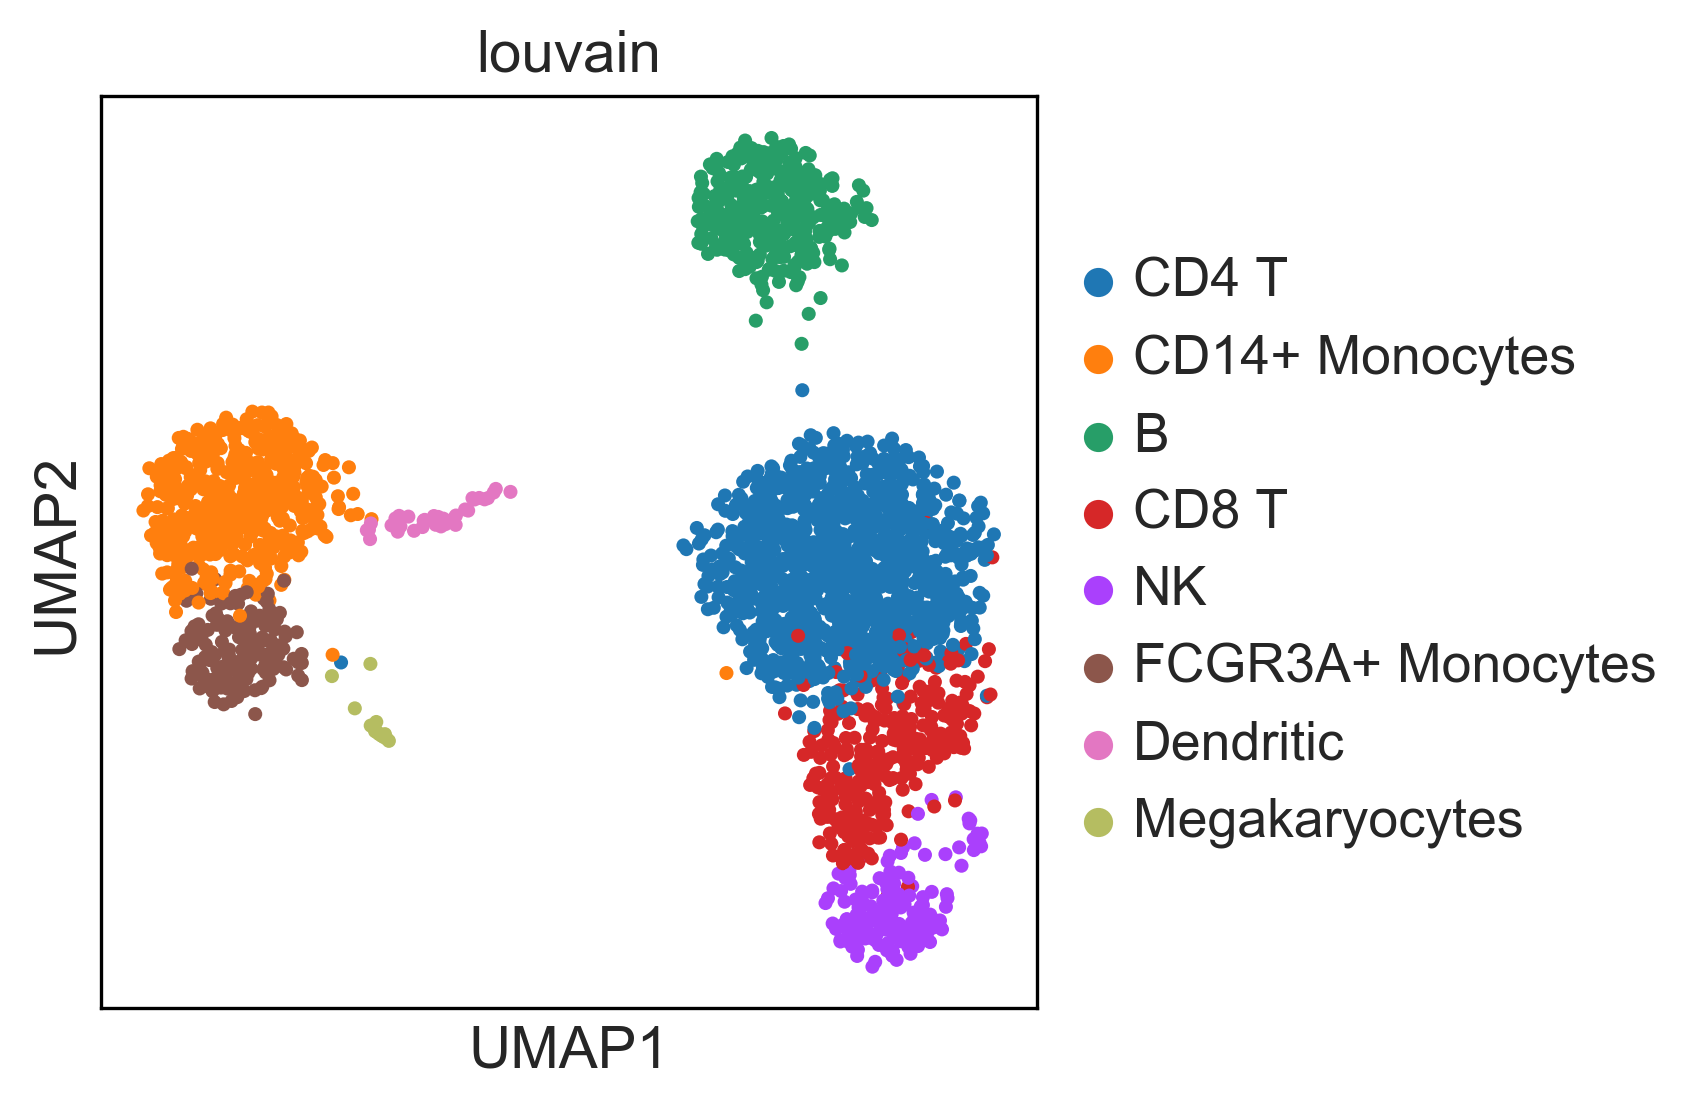

In [3]:
sc.pl.umap(adata, color=["louvain"])

# Inference of motif activity using SCEPIA

Now you can run `infer_motifs()` from the `scepia` package. The first time you run `infer_motifs()`, `scepia` will download the ENCODE data package. This will take some time, but the results will be saved in `~/.cache/scepia`. 

For TF motifs, the default [GimmeMotifs](https://gimmemotifs.readthedocs.org) motif database is used, but you can also use other motif databases. For instance, `pfm="JASPAR2020_vertebrates"` or `pfm="HOMER"`. Alternatively, you can also supply a file name with your own motifs in PFM format.

By default, `infer_motifs()` uses 10,000 variable enhancers for motif analysis. You can change this using the `num_enhancers` argument. In any case, only the enhancers near (<100kb) the selected hypervariable genes will be used. 

In [4]:
adata = infer_motifs(adata, dataset="ENCODE")

# Use the following command to infer motif activity for JASPAR motifs:
# adata = infer_motifs(adata, dataset="ENCODE", pfm="JASPAR2020_vertebrates")

2019-12-06 09:49:07 - INFO - loading reference data
2019-12-06 09:49:59 - INFO - selecting reference cell types
2019-12-06 09:50:16 - INFO - 48 out of 121 selected
2019-12-06 09:50:16 - INFO - top 5:
2019-12-06 09:50:16 - INFO -  * natural killer cell
2019-12-06 09:50:16 - INFO -  * coronary artery
2019-12-06 09:50:16 - INFO -  * psoas muscle
2019-12-06 09:50:16 - INFO -  * T-helper 17 cell
2019-12-06 09:50:16 - INFO -  * effector memory CD4-positive, alpha-beta T cell
2019-12-06 09:50:16 - INFO - linking variable genes to differential enhancers
2019-12-06 09:50:54 - INFO - inferring motif activity
/home/simon/anaconda3/envs/gimme/lib/python3.6/site-packages/gimmemotifs-0.13.1+222.g7186204-py3.6-linux-x86_64.egg/gimmemotifs/../data/motif_databases/gimme.vertebrate.v5.0.pfm
scanning for motifs
2019-12-06 09:50:57,239 - INFO - motif scanning (scores)
2019-12-06 09:50:57,241 - INFO - reading table
2019-12-06 09:51:00,449 - INFO - creating score table (z-score, GC%)
2019-12-06 09:54:37,135

2019-12-06 10:11:59,396 - INFO - Done


2019-12-06 10:11:59 - INFO - annotating cells


2019-12-06 10:13:15 - INFO - calculating cell-specific motif activity
2019-12-06 10:13:15 - INFO - correlating TFs with motifs


# Cell type annotation

The cell types of all single cells are annotated based on matching H3K27ac profiles. You can check this using the `cell_annotation` and the `cluster_annotation` properties that are stored in `adata.obs`. The `cluster_annotation` is just the majority vote of all cell types in the cluster.

... storing 'cell_annotation' as categorical
... storing 'cluster_annotation' as categorical


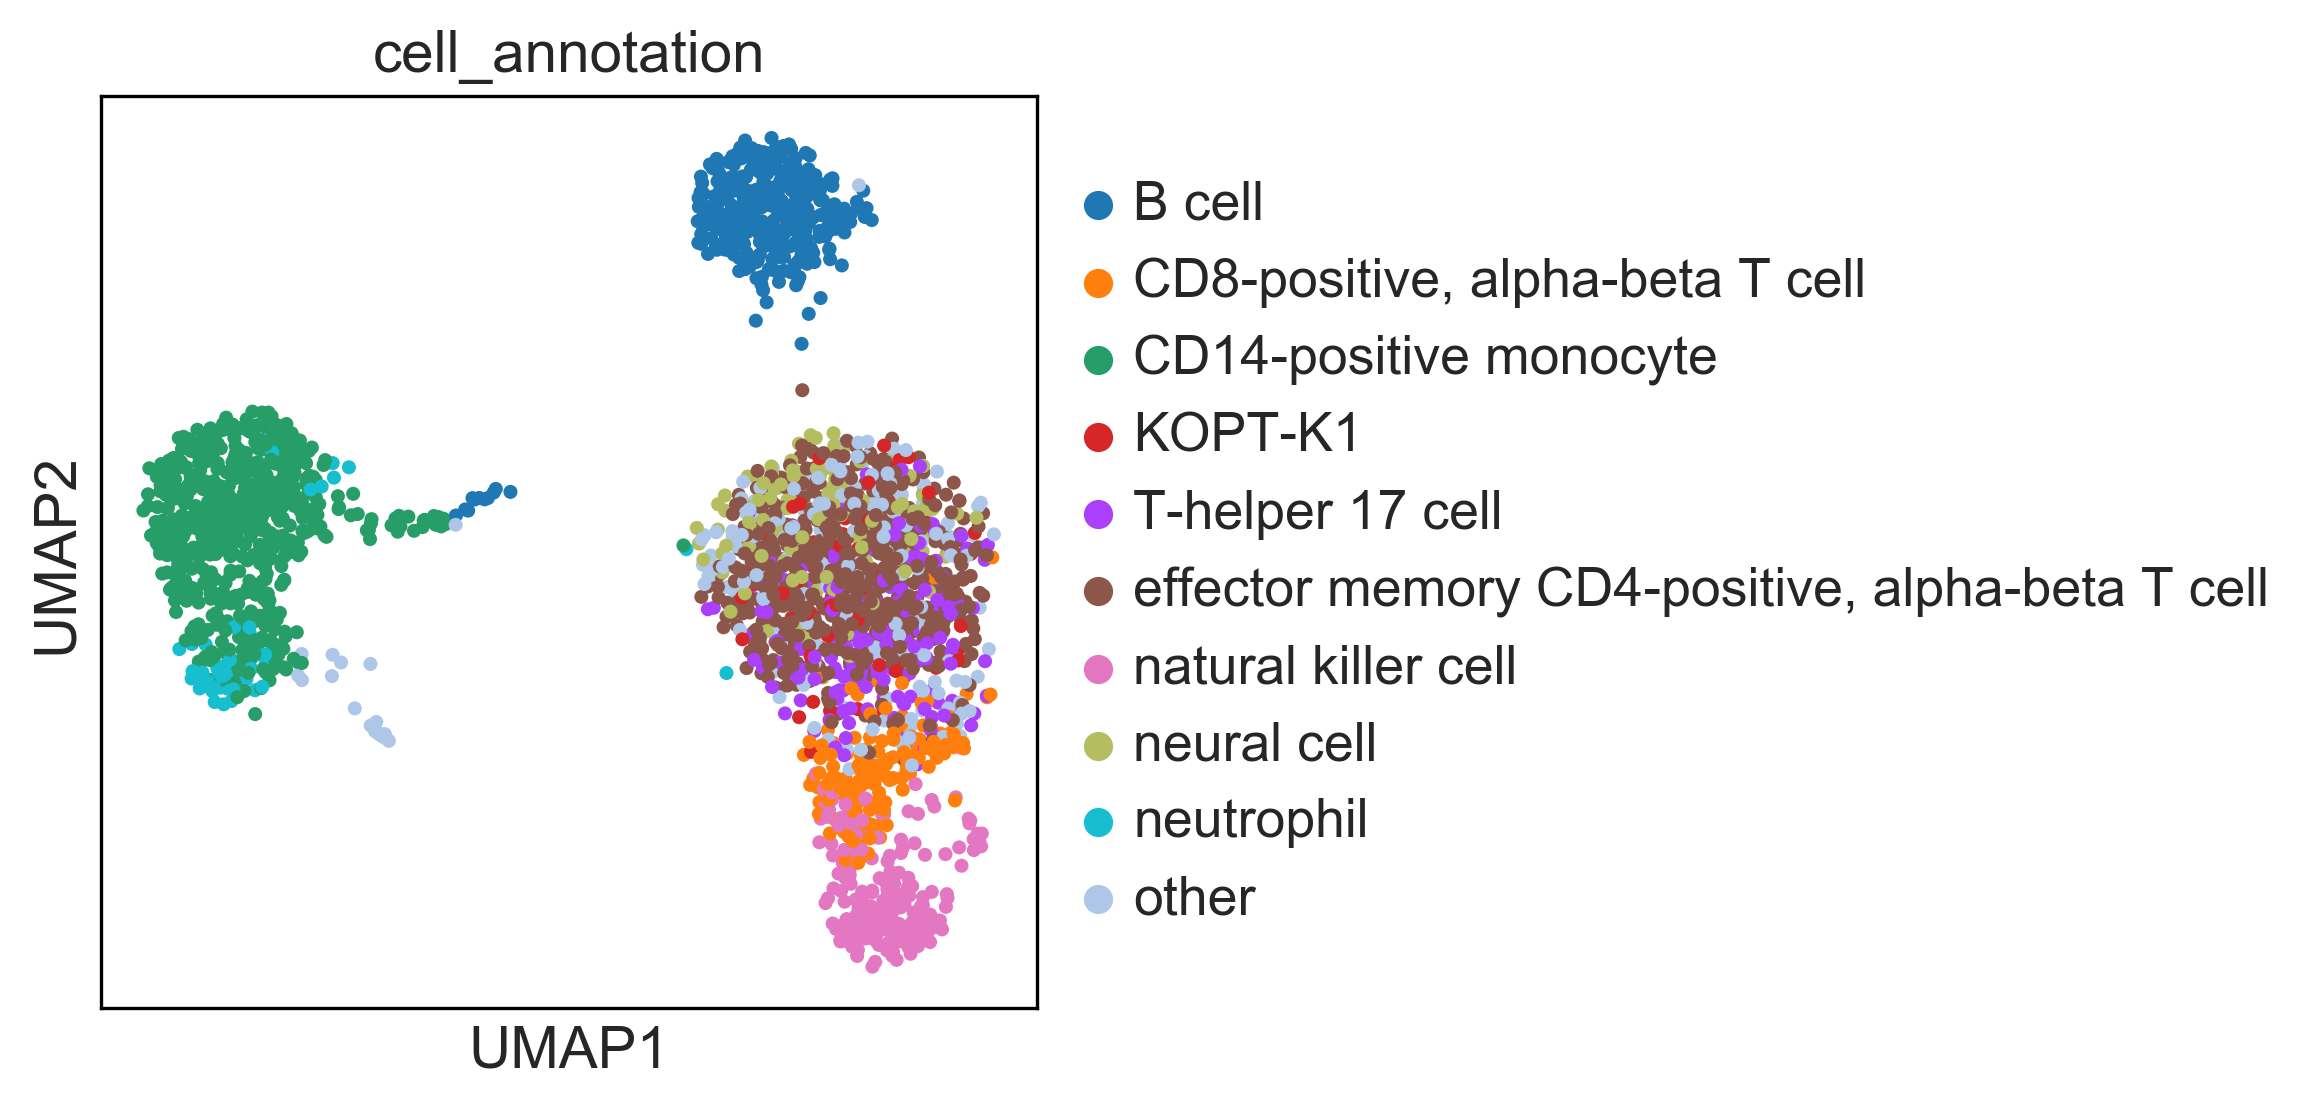

In [5]:
sc.pl.umap(adata, color="cell_annotation")

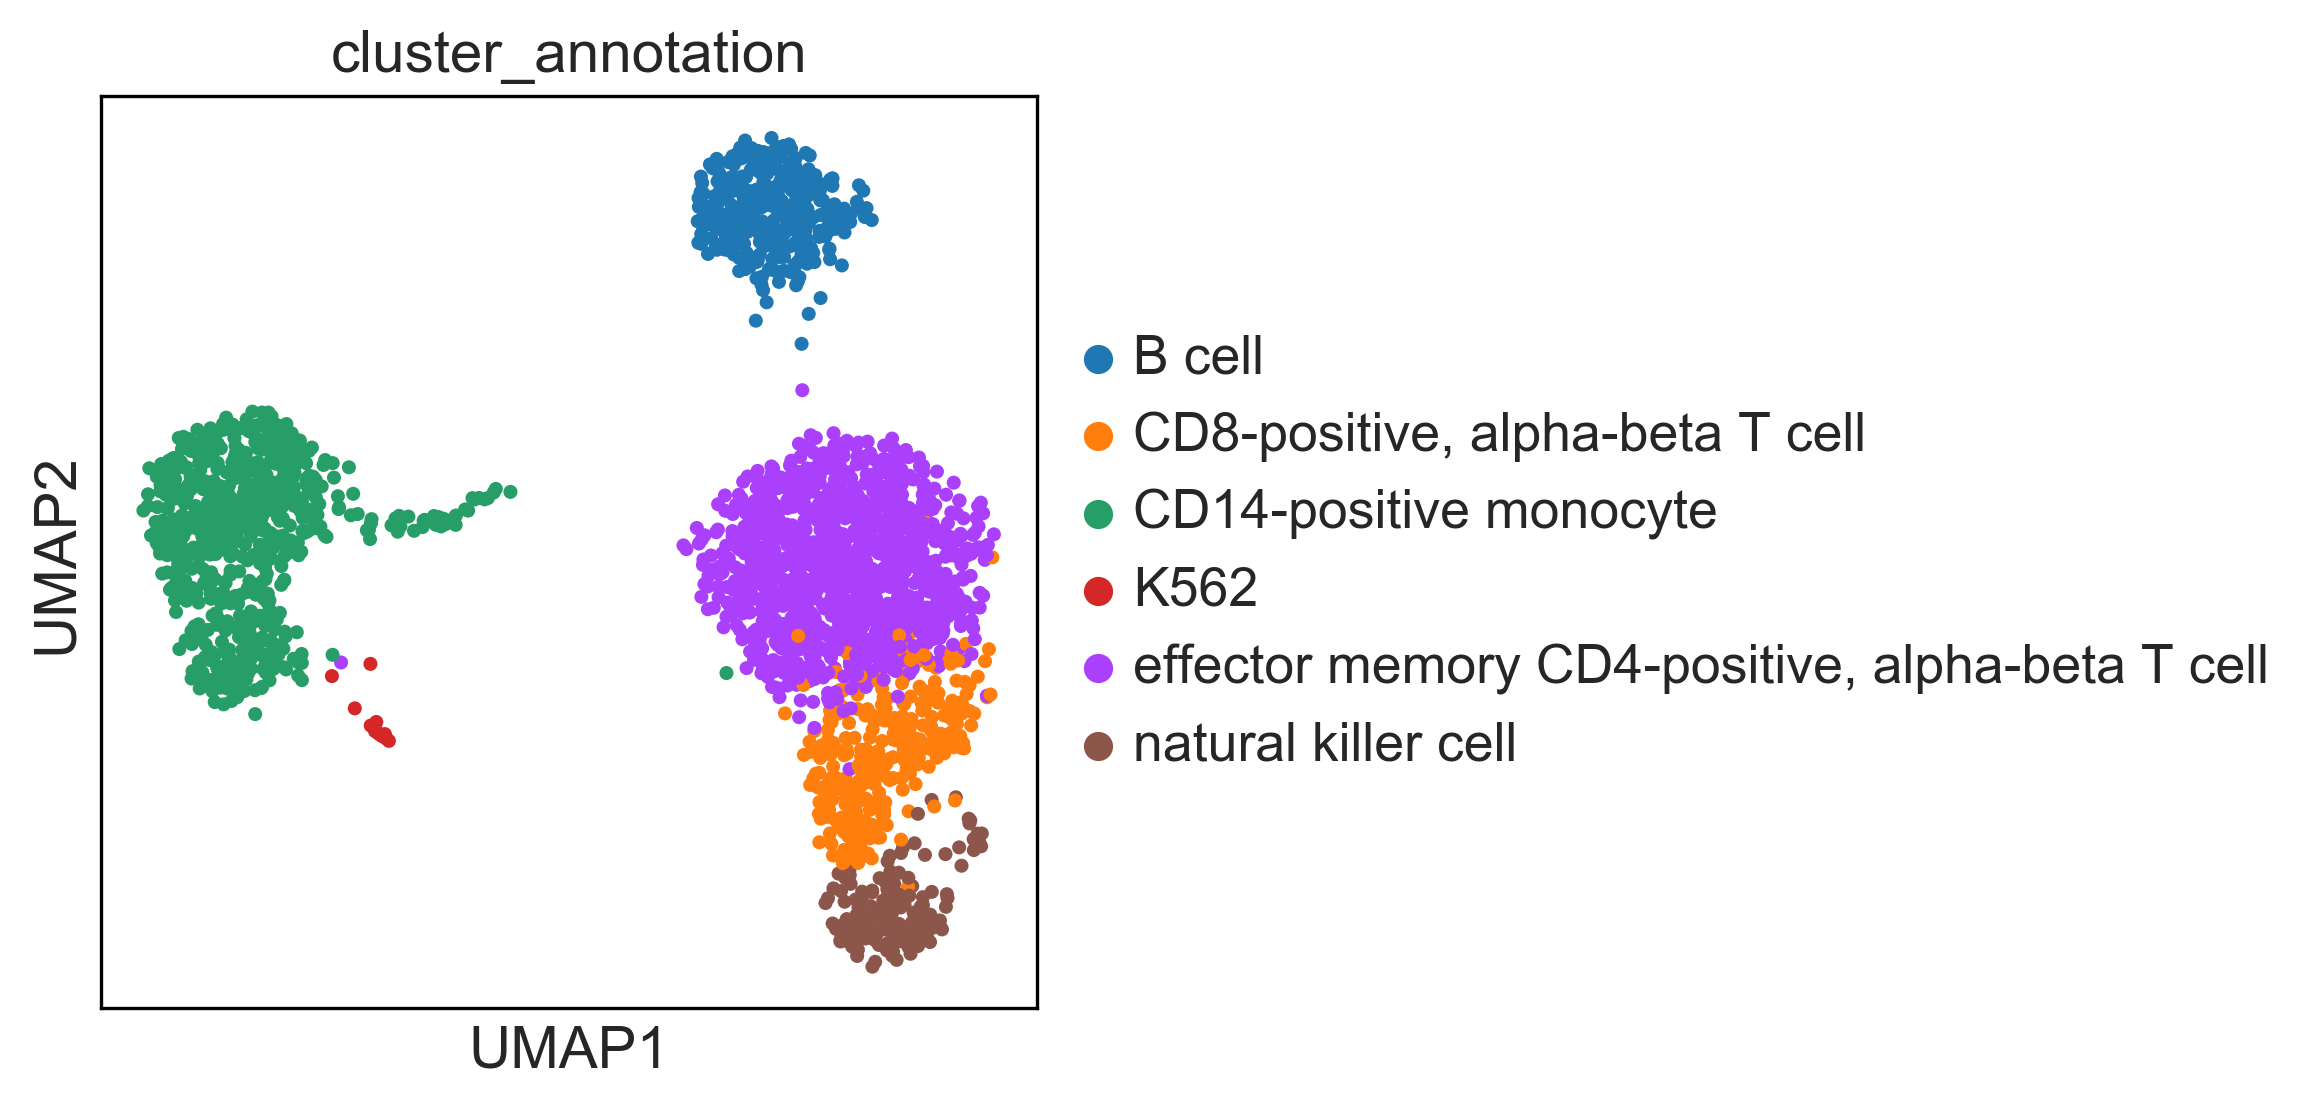

In [6]:
sc.pl.umap(adata, color="cluster_annotation")

The `scepia` cell type annotation only shows the most important cell type per single cell. However, the inferred H3K27ac profiles are a combination of multiple different cell types. Additionally, the cell types do not need to match perfectly to result in relevant motifs.

In this example, we can see that the most of the inferred cell types are reasonable. There is no megakaryocyte reference data in ENCODE, the closest cell type here is K562. As this cell line has erythroid-like properties, this makes sense. Some monocyte cells match neutrophils, which are very close. The T cells also match KOPT-K1, which is an Acute Lymphoblastic Leukaemia cell line that originates from T cells. Only the "neural cell" annotation is puzzling. These are H1 cells in vitro differentiated to a neural lineage, and apparently they express some genes that are also expressed in CD4 T cells.

When we look at the cluster-based annotation, we see that the annotation based on the majority vote is correct.

Let's look in a little more detail at the cells that were assigned a "neural cell" cell type. In general we can see that out of the top 5 cell types, 3 are T cells and one is a mesodermal cell type. All hematopoietic cell types of the other clusters get negative coefficients. This illustrates why the inferred motif activity will still be fine for these cells, even if top cell type is not accurate. In essence, the top cell type is a simplified view of the cell type inference.

In [7]:
cell_types = pd.DataFrame(
    adata.obsm["X_cell_types"],                 # cell type coefficients are stored here
    index=adata.obs_names,                      # cell bar codes
    columns=adata.uns["scepia"]["cell_types"])  # cell type names

# Get all cells that are annotated as "neural cell"
cell_types = cell_types[adata.obs["cell_annotation"] == "neural cell"]
# Summarize coefficients over all these cells
mean_cell_type_coef = cell_types.mean(0).sort_values()

print("Positive cell type coefficients:")
print(mean_cell_type_coef.tail(5))
print()
print("Negative cell type coefficients:")
print(mean_cell_type_coef.head(5))

Positive cell type coefficients:
cardiac muscle cell                                0.002994
T-helper 17 cell                                   0.003637
KOPT-K1                                            0.003895
effector memory CD4-positive, alpha-beta T cell    0.007053
neural cell                                        0.010234
dtype: float64

Negative cell type coefficients:
CD14-positive monocyte   -0.010394
neutrophil               -0.006530
natural killer cell      -0.005732
B cell                   -0.003593
Karpas-422               -0.003432
dtype: float64


# Motif activity

Most of the results from `infer_motifs()` are stored in `adata.uns['scepia']`. 

In [8]:
adata.uns["scepia"].keys()

dict_keys(['cell_types', 'pfm', 'motif_activity', 'factor2motif'])

The value of `adata.uns["scepia"]["factor2motif"]` is a pandas DataFrame with results of the correlation between inferred motif activity and expression of the transcription factor. This can already be used to prioritize relevant motifs.

In [9]:
adata.uns["scepia"]["factor2motif"].sort_values("pval").head(20)

motif factor      corr           pval           padj  \
1482         GM.5.0.bZIP.0052  CEBPD  0.590883  3.928075e-248  9.439164e-245   
1281         GM.5.0.bZIP.0039  CEBPD  0.589987  3.342026e-247  4.015444e-244   
26            GM.5.0.Ets.0001   SPI1  0.582843  6.913583e-240  5.537780e-237   
905           GM.5.0.Ets.0014   SPI1  0.541672  4.579038e-201  2.750857e-198   
1483         GM.5.0.bZIP.0052  CEBPB  0.478791  2.948207e-151  1.416908e-148   
356          GM.5.0.bZIP.0011  CEBPB  0.476997  5.532420e-150  2.073697e-147   
1284         GM.5.0.bZIP.0039  CEBPB  0.476943  6.040733e-150  2.073697e-147   
1308         GM.5.0.bZIP.0042  CEBPB  0.473795  9.940316e-148  2.985822e-145   
945           GM.5.0.Ets.0015   SPI1  0.462061  1.140107e-139  3.044085e-137   
678           GM.5.0.Ets.0010   SPI1  0.437911  4.820635e-124  1.158399e-121   
752   GM.5.0.Homeodomain.0047  GATA2  0.434059  1.149818e-121  2.511829e-119   
1627         GM.5.0.bZIP.0062  CEBPB  0.425679  1.344074e-116  2.691507e-114   
1862      GM.5.0.C2H2_ZF.0203   KLF4  0.400230  4.601583e-102  8.505849e-100   
2138         GM.5.0.bZIP.0091   MAFB -0.363706   2.585636e-83   4.438059e-81   
982         GM.5.0.Mixed.0027   IRF8  0.362224   1.329661e-82   2.130117e-80   
217       GM.5.0.C2H2_ZF.0009   KLF4  0.355094   3.104821e-79   4.663053e-77   
516          GM.5.0.bZIP.0015  CEBPB  0.352443   5.278655e-78   7.461534e-76   
409          GM.5.0.bZIP.0013  CEBPB  0.329929   5.070150e-68   6.768650e-66   
254       GM.5.0.C2H2_ZF.0013   KLF4  0.326651   1.229511e-66   1.555008e-64   
177          GM.5.0.GATA.0003  GATA2  0.316286   2.280669e-62   2.740224e-60   

       abscorr putative_role  
1482  0.590883     activator  
1281  0.589987     activator  
26    0.582843     activator  
905   0.541672     activator  
1483  0.478791     activator  
356   0.476997     activator  
1284  0.476943     activator  
1308  0.473795     activator  
945   0.462061     activator  
678   0.437911     activator  
752   0.434059     activator  
1627  0.425679     activator  
1862  0.400230     activator  
2138  0.363706     repressor  
982   0.362224     activator  
217   0.355094     activator  
516   0.352443     activator  
409   0.329929     activator  
254   0.326651     activator  
177   0.316286     activator

You can visualize the inferred TF activity with the normal scanpy plotting functions, using `{FACTOR_NAME}_activity`. For instance, to plot the activity of two of the top factor, CEBPD and SPI1 (also known as PU.1):

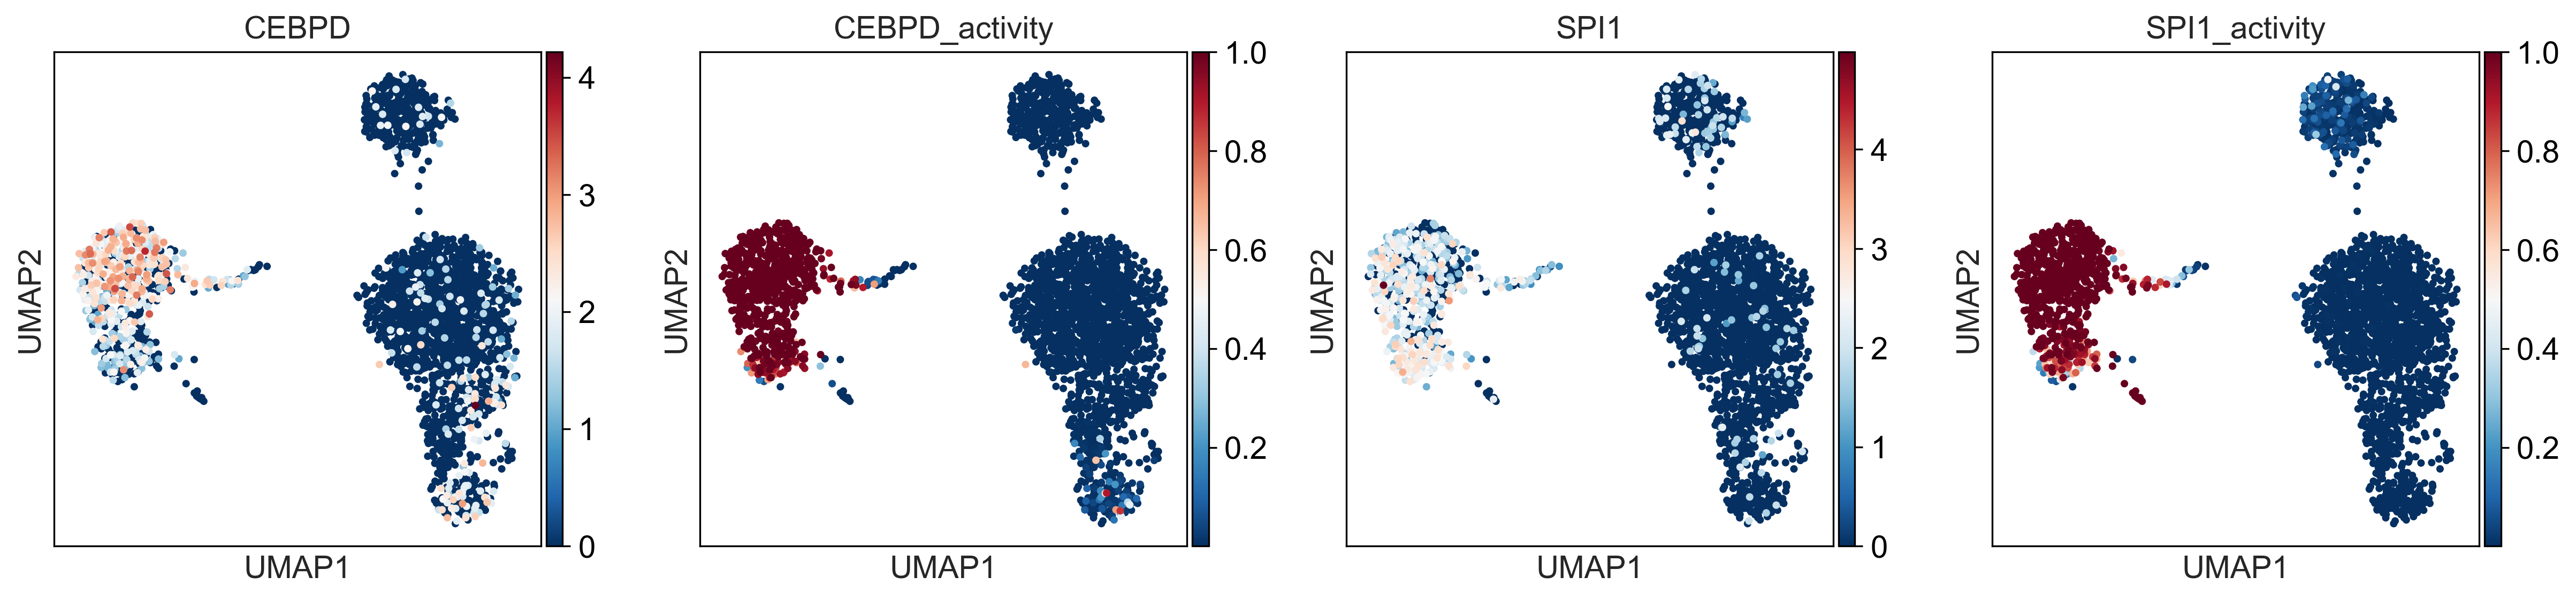

In [10]:
sc.pl.umap(adata, color=["CEBPD", "CEBPD_activity", "SPI1", "SPI1_activity"], cmap="RdBu_r")

**Please note:** this TF activity is based on the motif for that factor with the highest correlation. However, sometimes this assumption is incorrect. You can always check other motifs. 

In [11]:
f2m = adata.uns["scepia"]['factor2motif']
f2m[f2m["factor"] == "CEBPD"].sort_values("pval").head(5)

motif factor      corr           pval           padj  \
1482  GM.5.0.bZIP.0052  CEBPD  0.590883  3.928075e-248  9.439164e-245   
1281  GM.5.0.bZIP.0039  CEBPD  0.589987  3.342026e-247  4.015444e-244   
1616  GM.5.0.bZIP.0061  CEBPD -0.034553   7.599817e-02   1.850290e-01   

       abscorr putative_role  
1482  0.590883     activator  
1281  0.589987     activator  
1616  0.034553     repressor

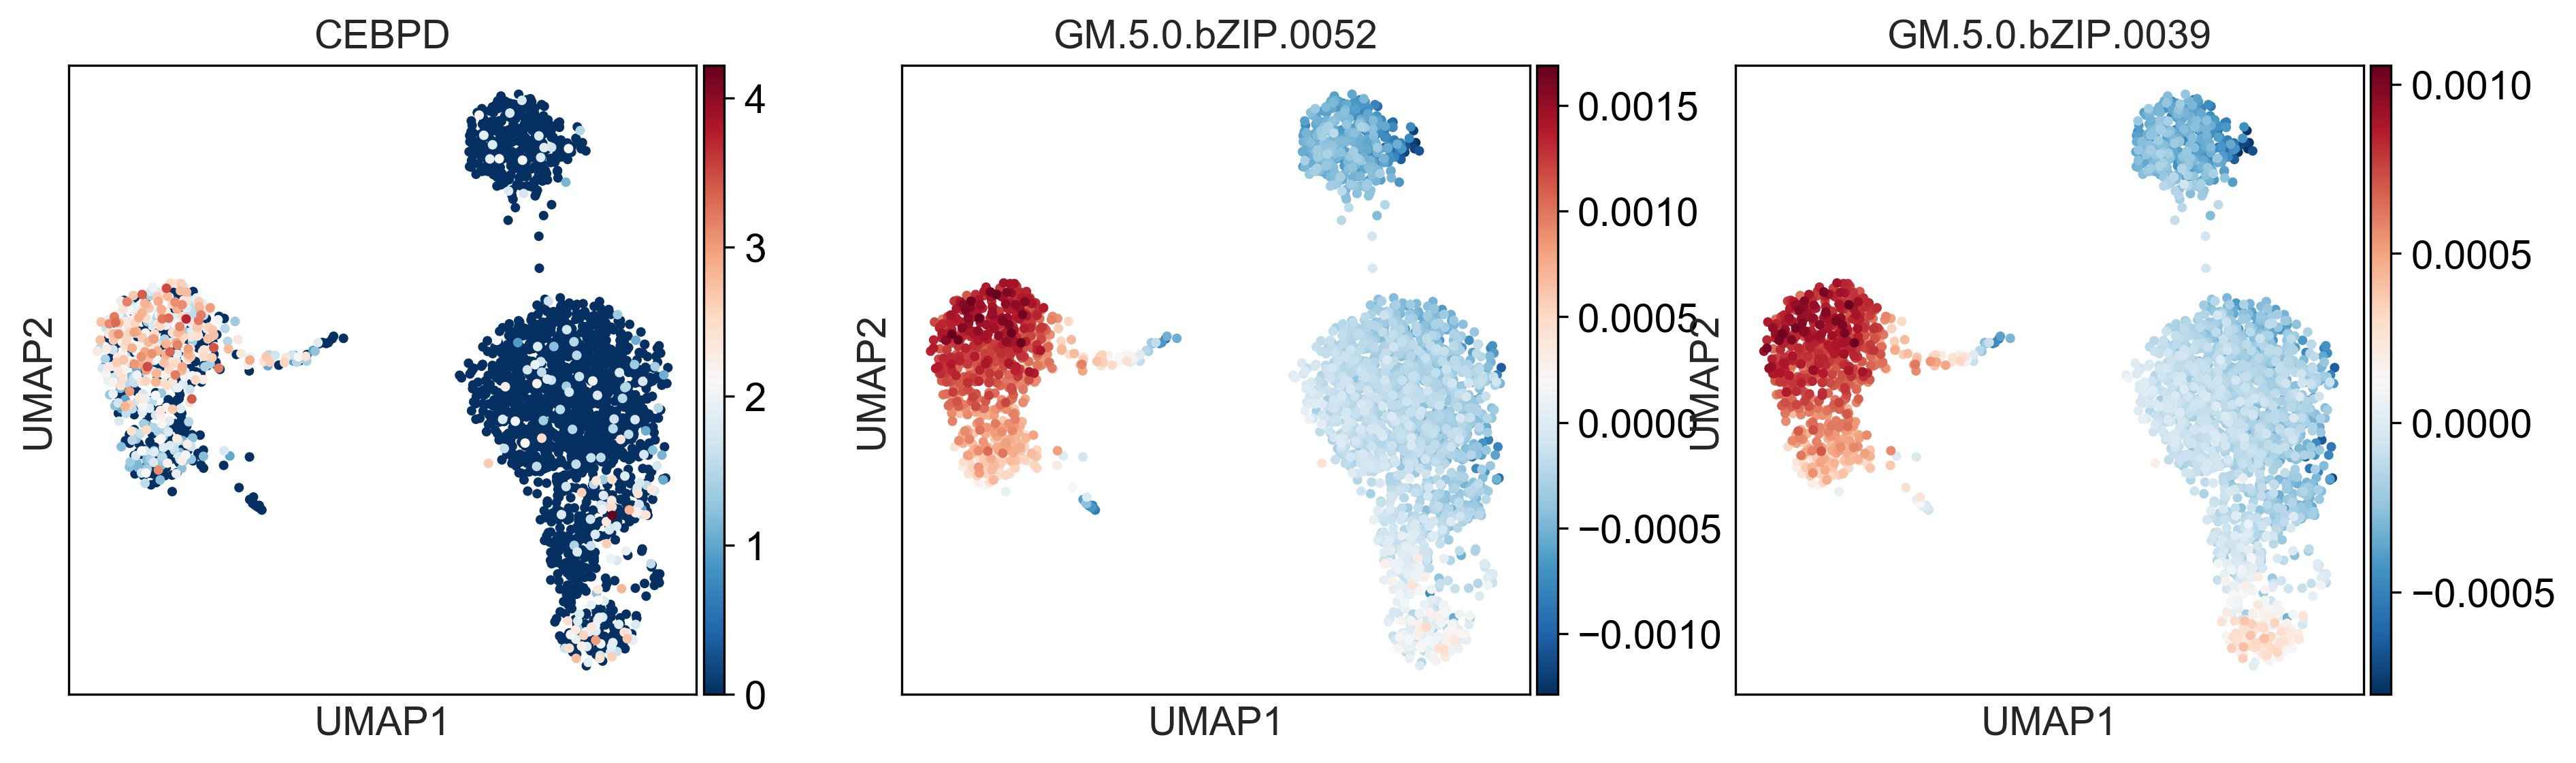

In [12]:
sc.pl.umap(adata, color=["CEBPD", "GM.5.0.bZIP.0052", "GM.5.0.bZIP.0039"], cmap="RdBu_r")

The correlation between motif and transcription factor is usually already very informative. However, cells that are similar will receive a similar cell type assignment and therefore a similar motif activity profile. On the other hand, cells that are similar will als tend to express similar TFs. This means that motifs will sometimes be highly correlated to TF expression, even if the motif is not relevant. Therefore, we can randomize the motif activity and derive an empirical p-value. This does take some time.

In [13]:
determine_significance(adata)

2019-12-06 10:14:01 - INFO - running Monte Carlo


Now, you can plot the correlated between TF and motif activity and the significance (-log10 of the p-value) in a volcano plot.

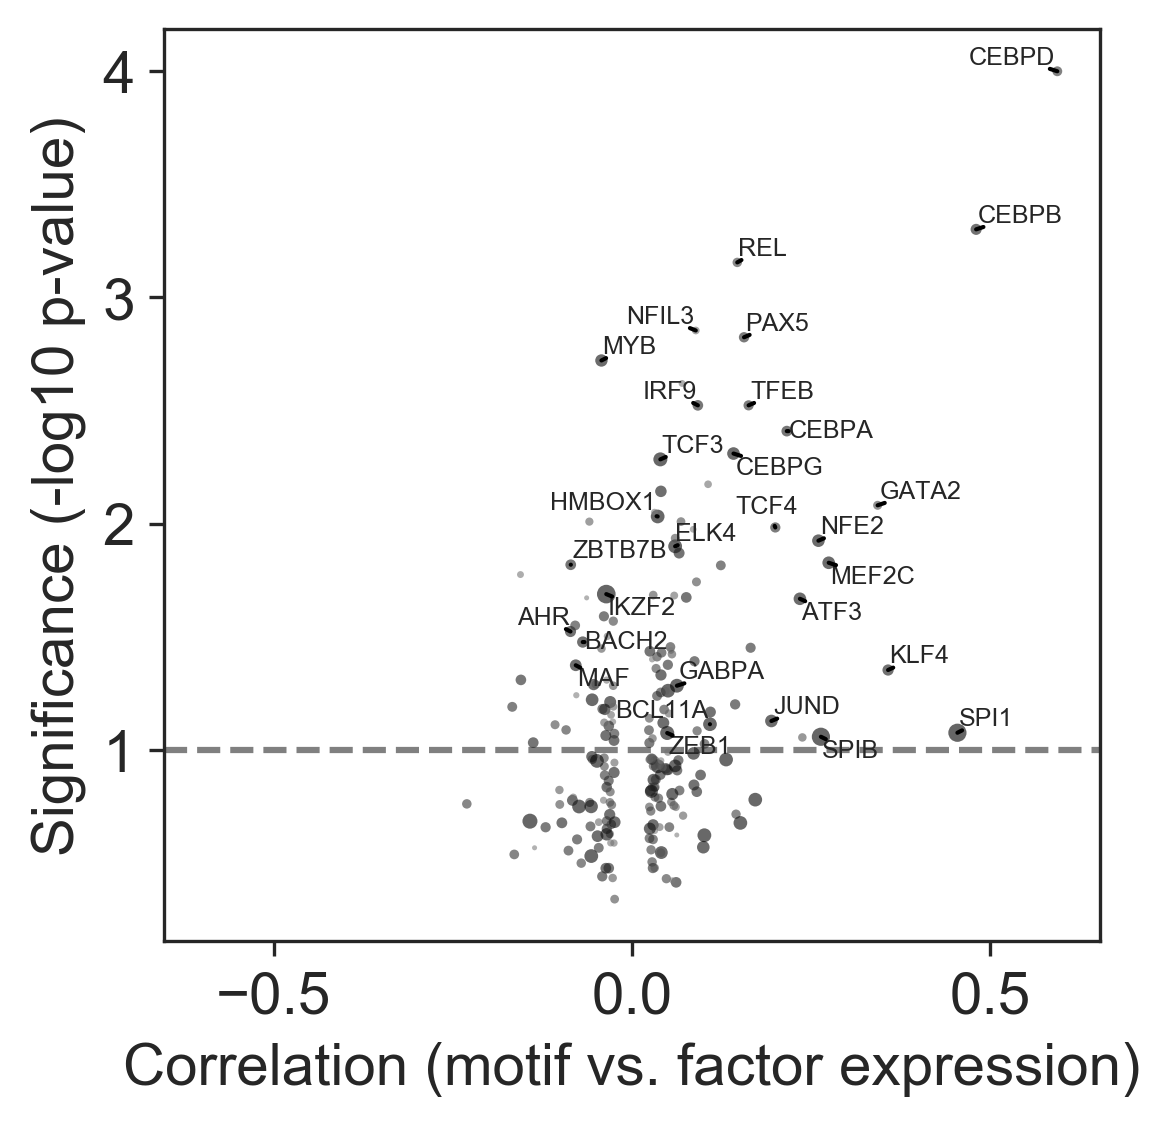

In [14]:
ax = plot_volcano_corr(adata, n_anno=30)

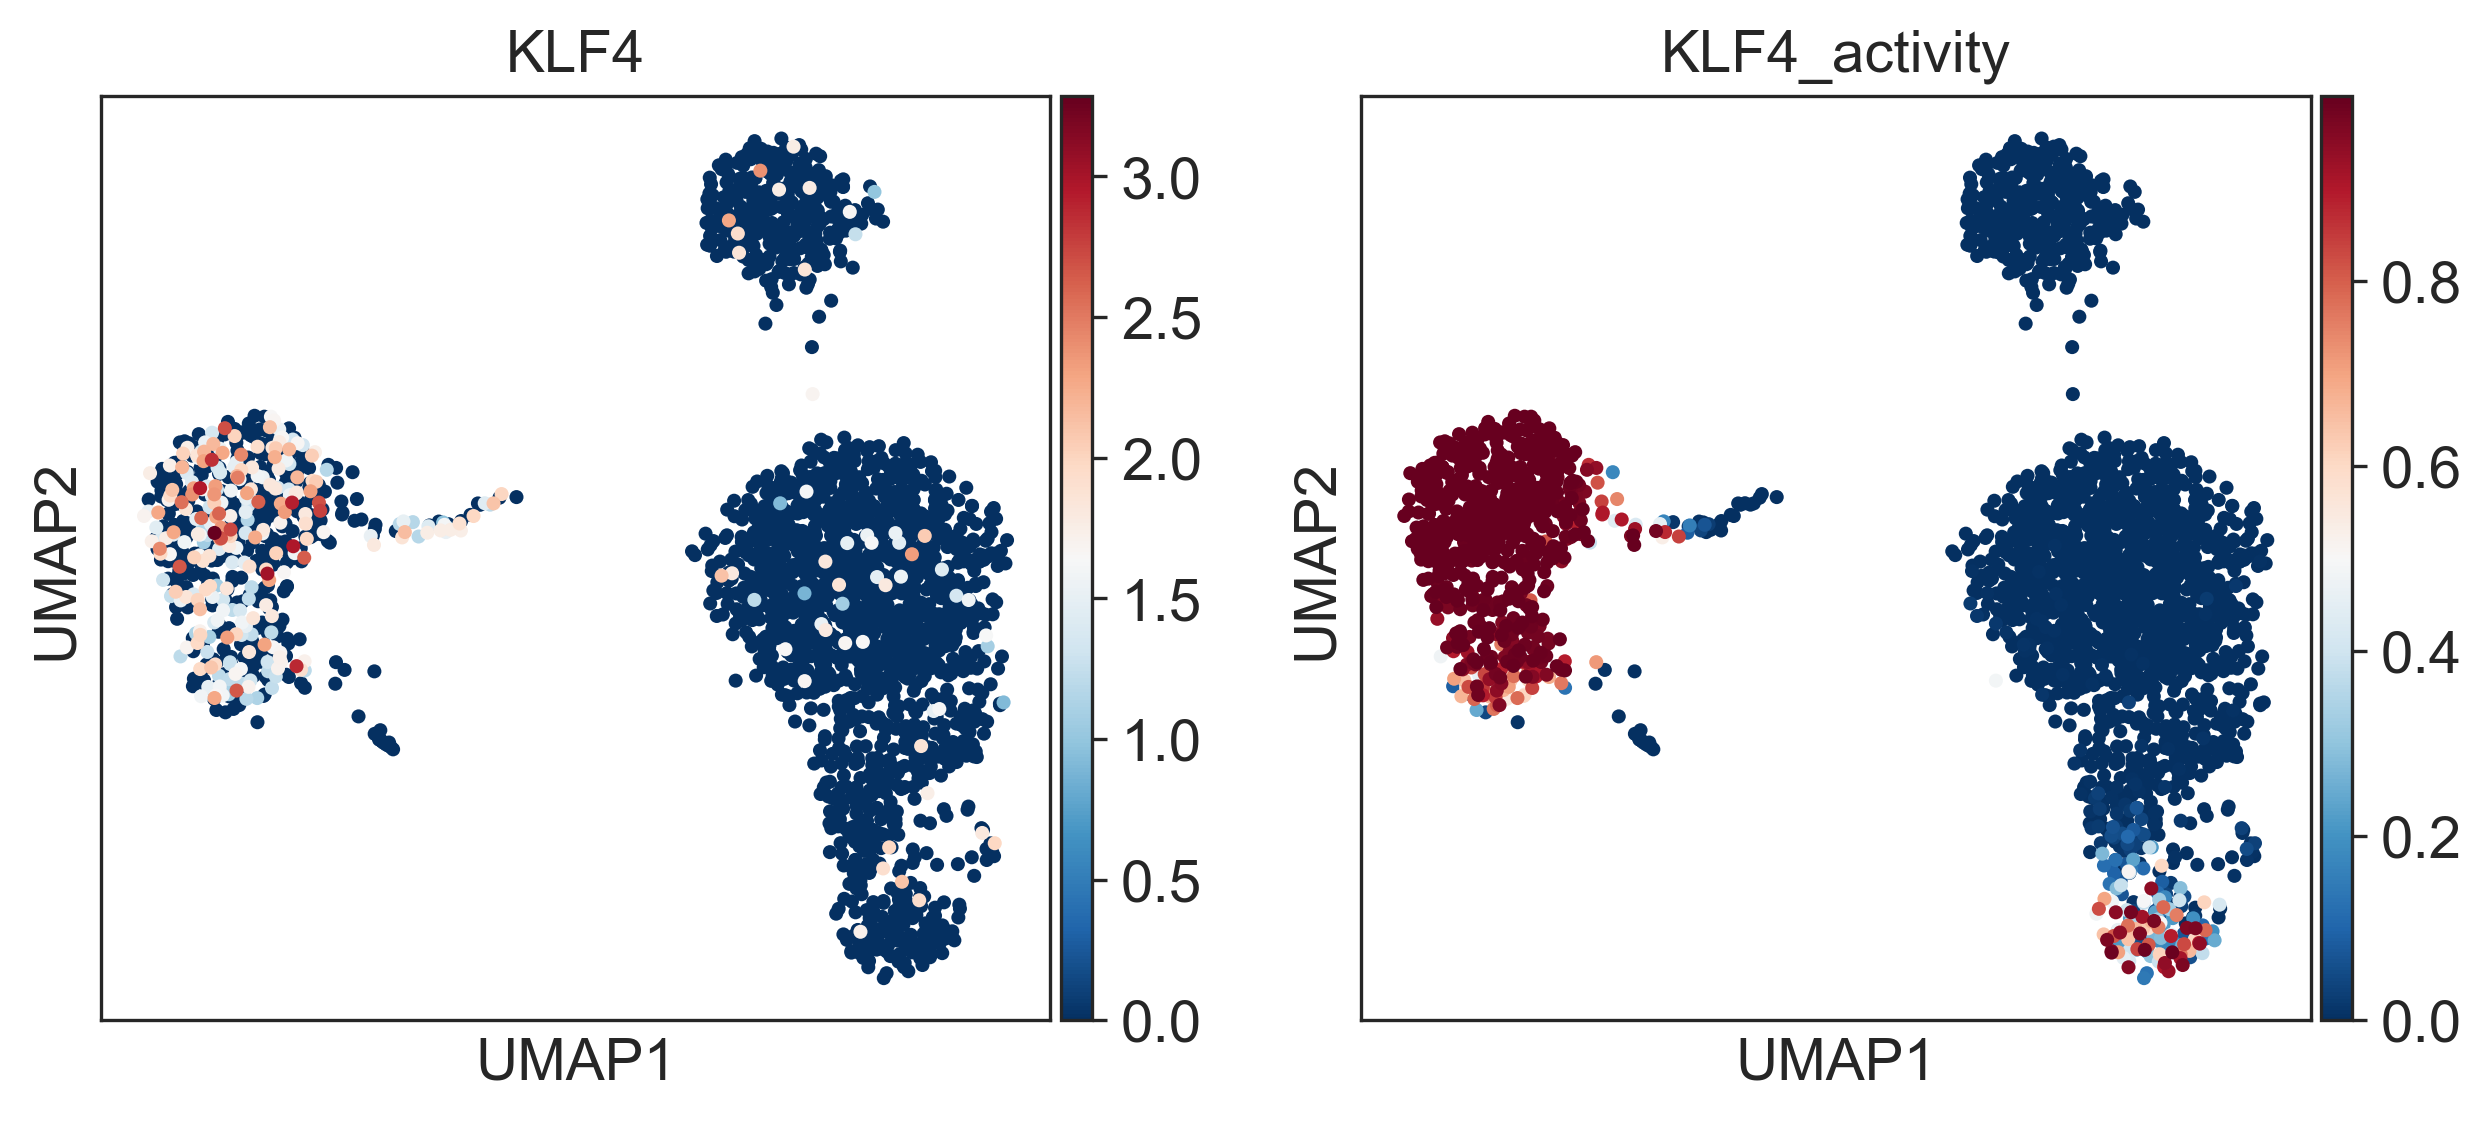

In [15]:
sc.pl.umap(adata, color=["KLF4", "KLF4_activity"], cmap="RdBu_r")

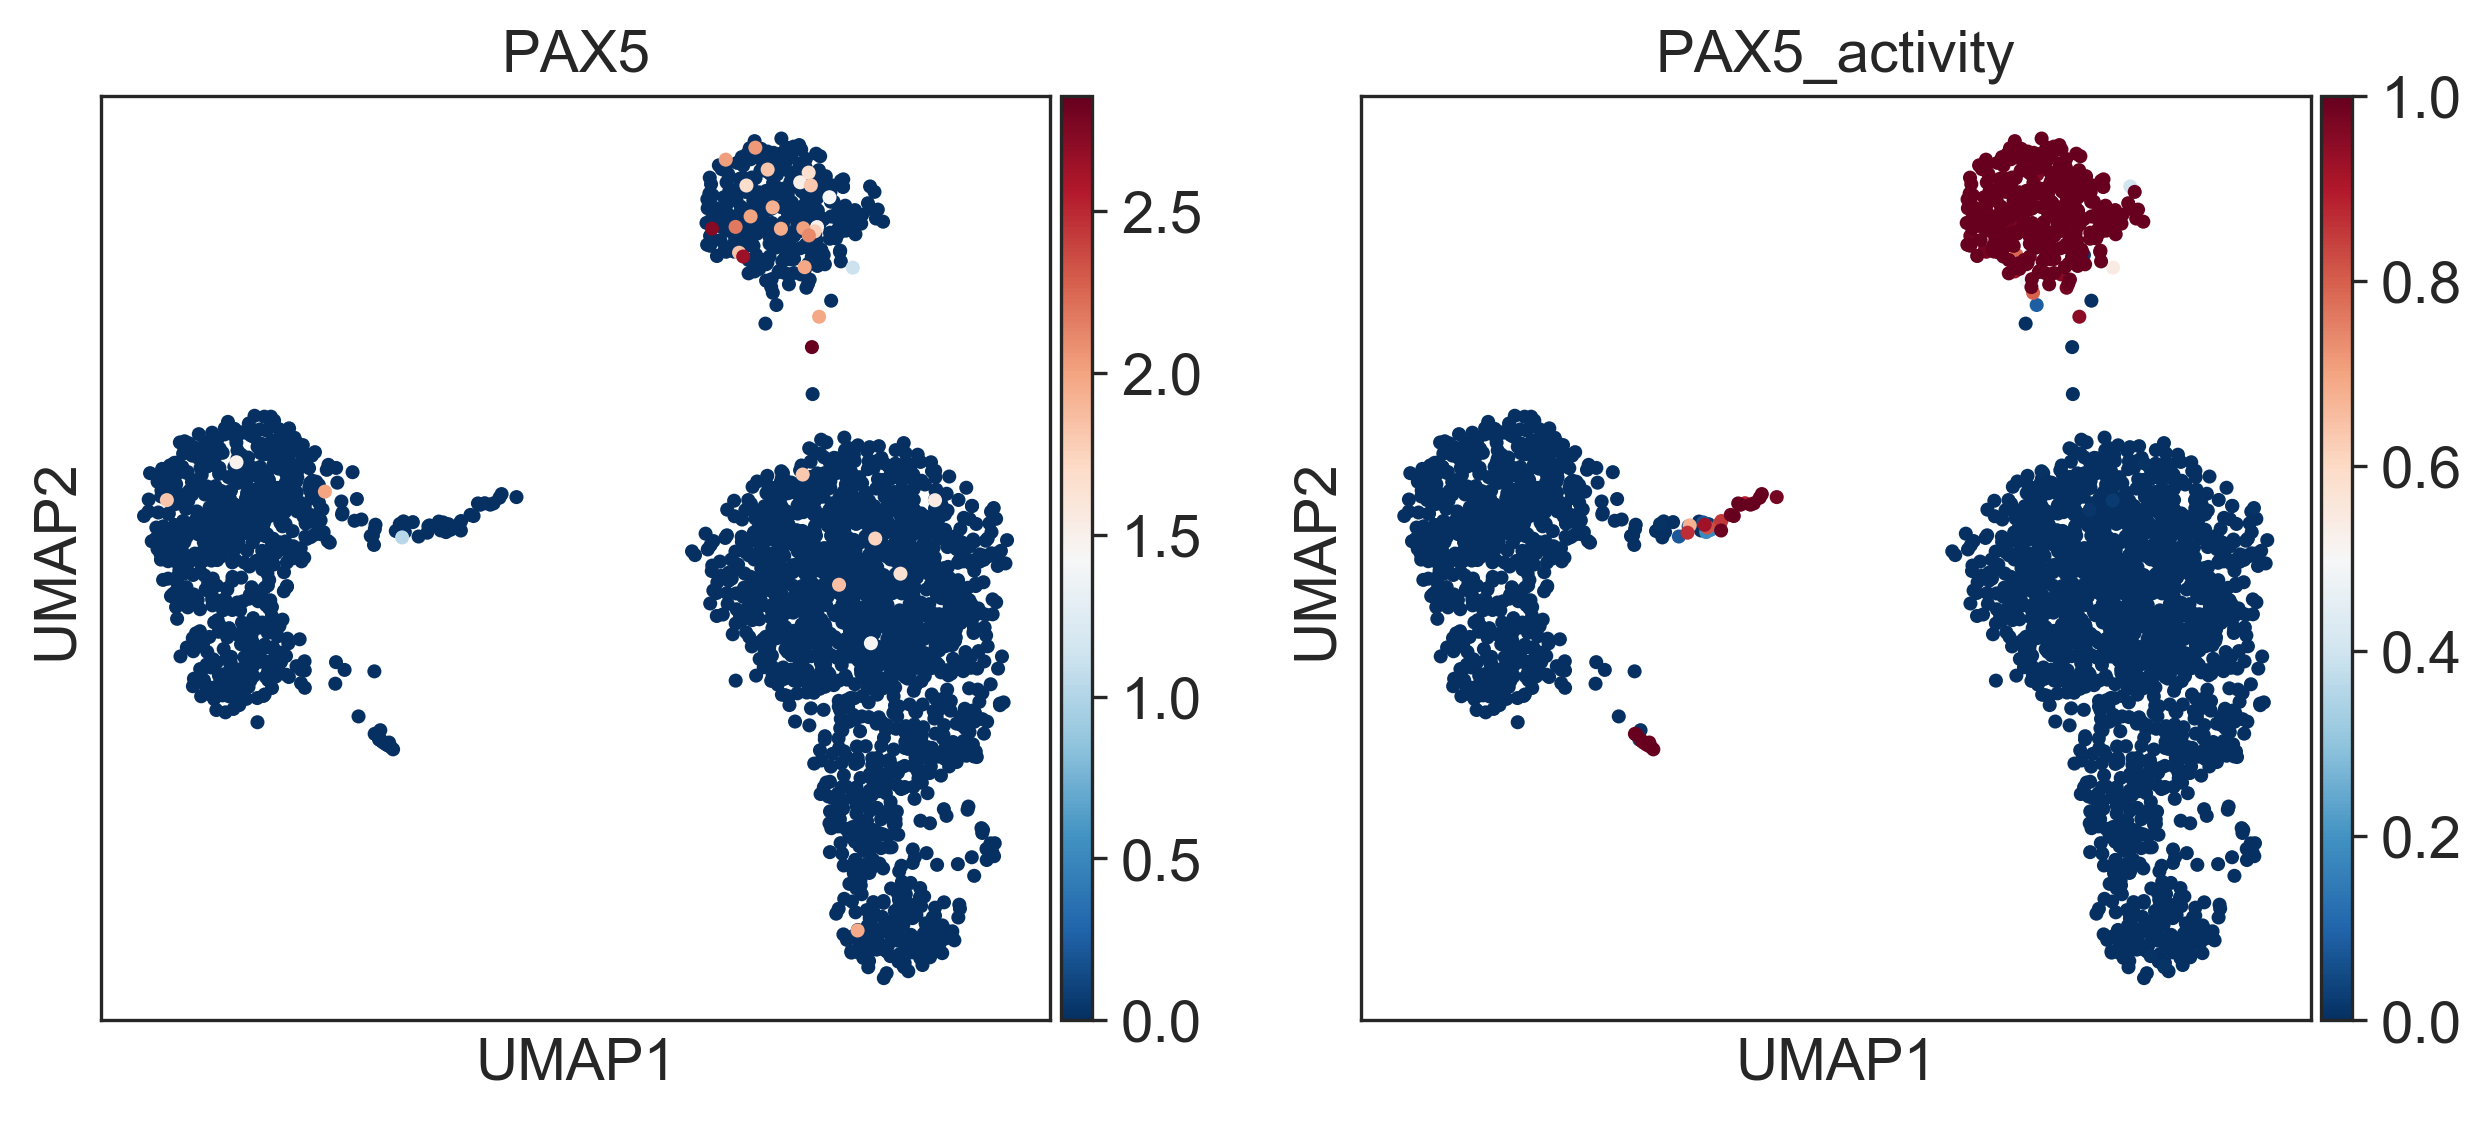

In [16]:
sc.pl.umap(adata, color=["PAX5", "PAX5_activity"], cmap="RdBu_r")

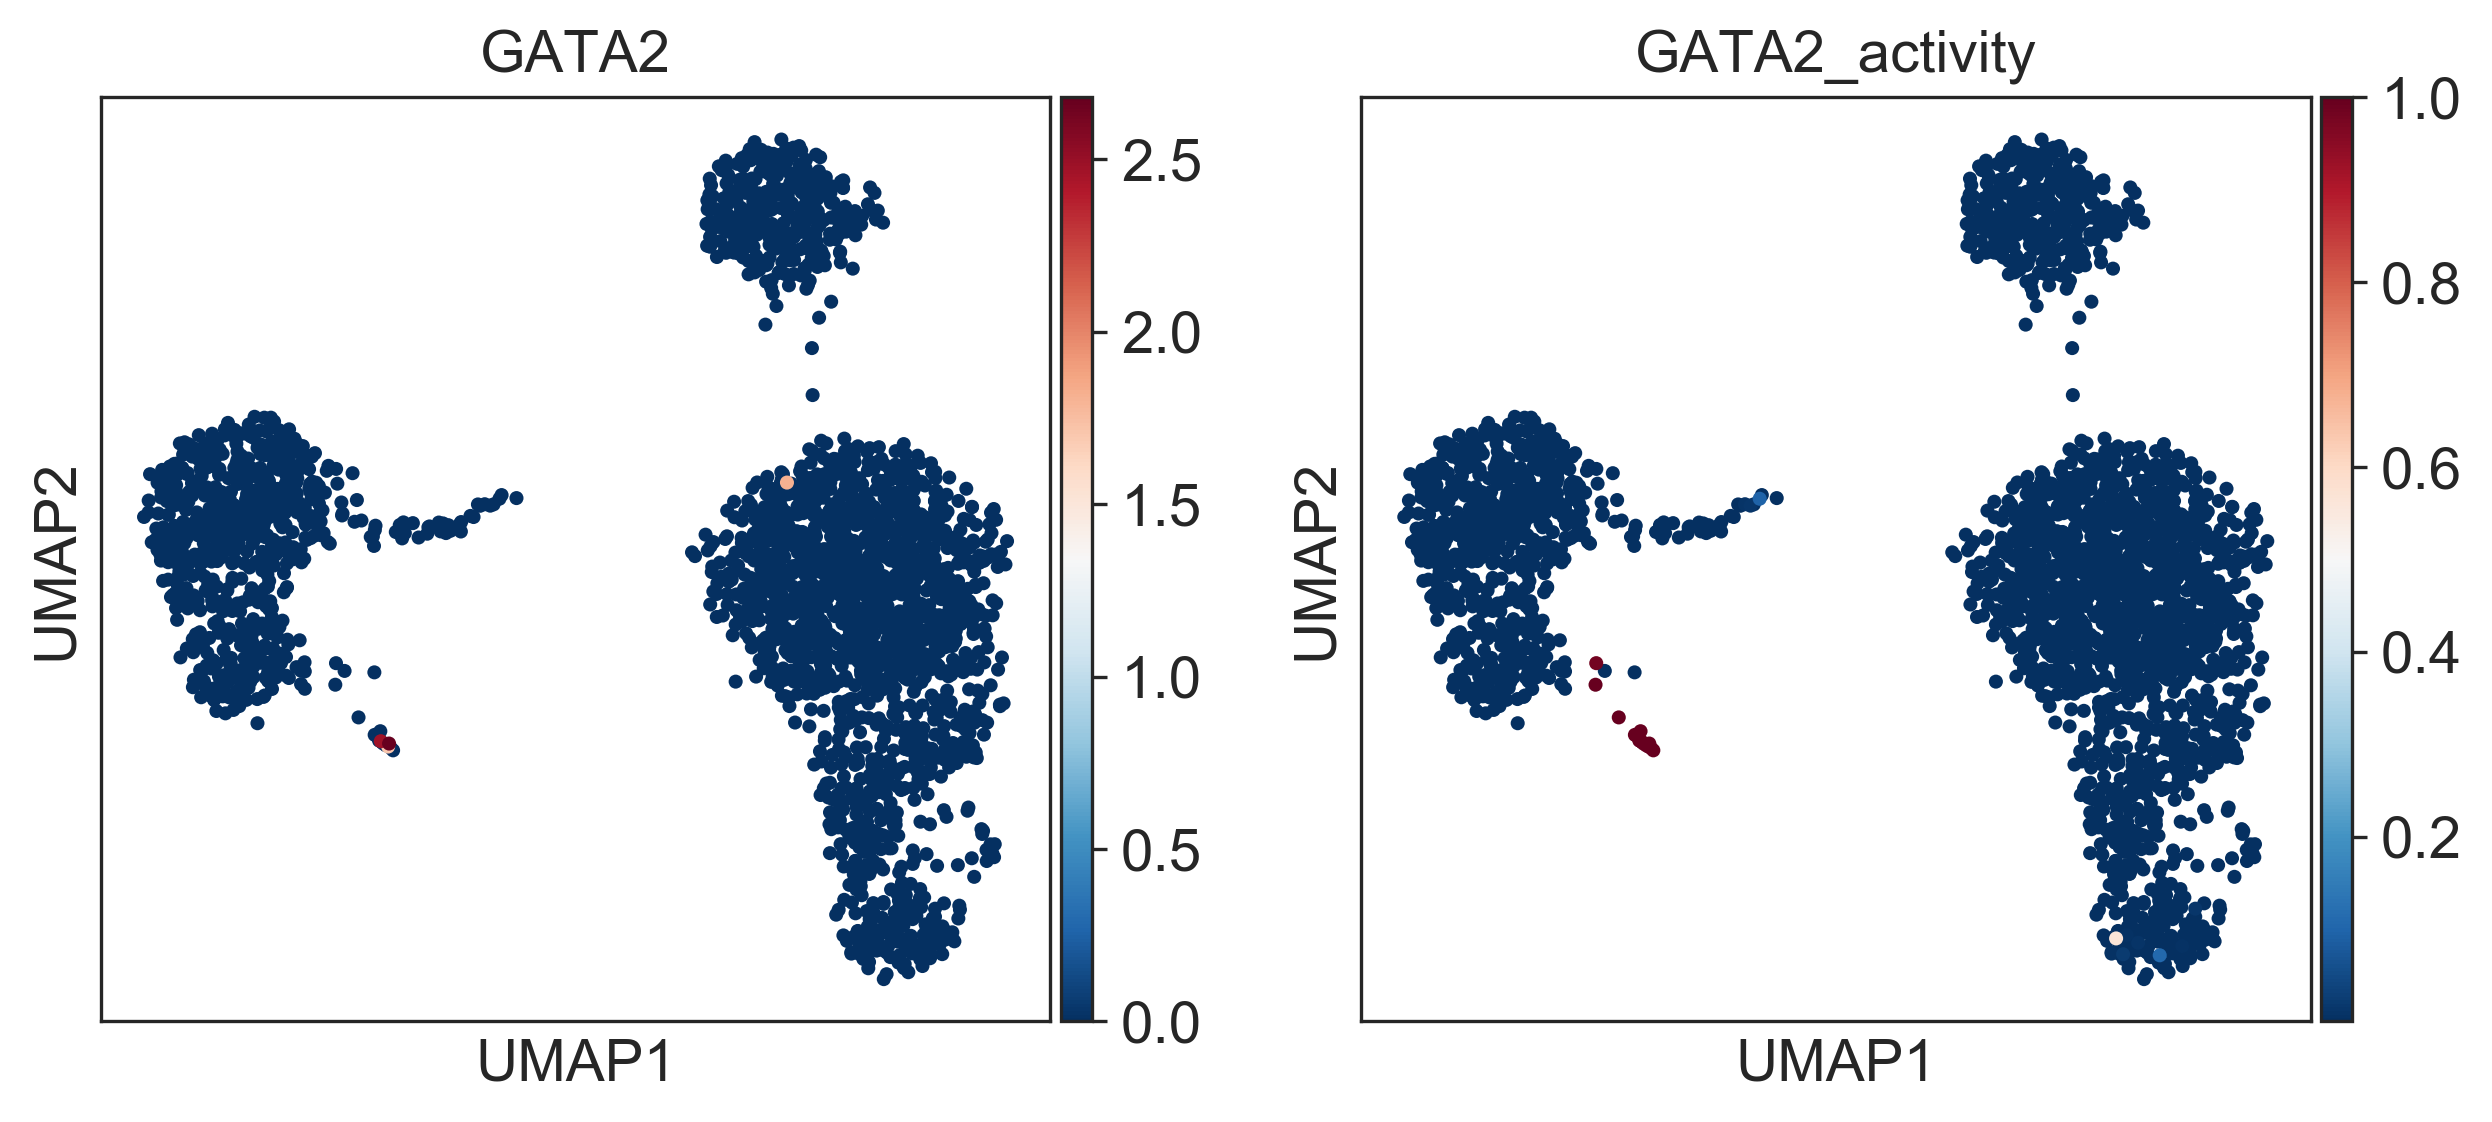

In [17]:
sc.pl.umap(adata, color=["GATA2", "GATA2_activity"], cmap="RdBu_r")

# Saving SCEPIA reults

You can save the `AnnData` object using `write()`. However, you have to use a `scepia`-specific function to load it. The default `read()` method of scanpy doesn't work.

In [19]:
adata.write('PBMC3K.scepia.h5ad')

In [20]:
# If you ever want to read it back
from scepia.sc import read
adata = read('PBMC3K.scepia.h5ad')

2019-12-06 11:25:01 - INFO - reading .h5ad file
2019-12-06 11:27:12 - INFO - done
2019-12-06 11:27:12 - INFO - converting and populating scepia motif properties
2019-12-06 11:27:12 - INFO - done


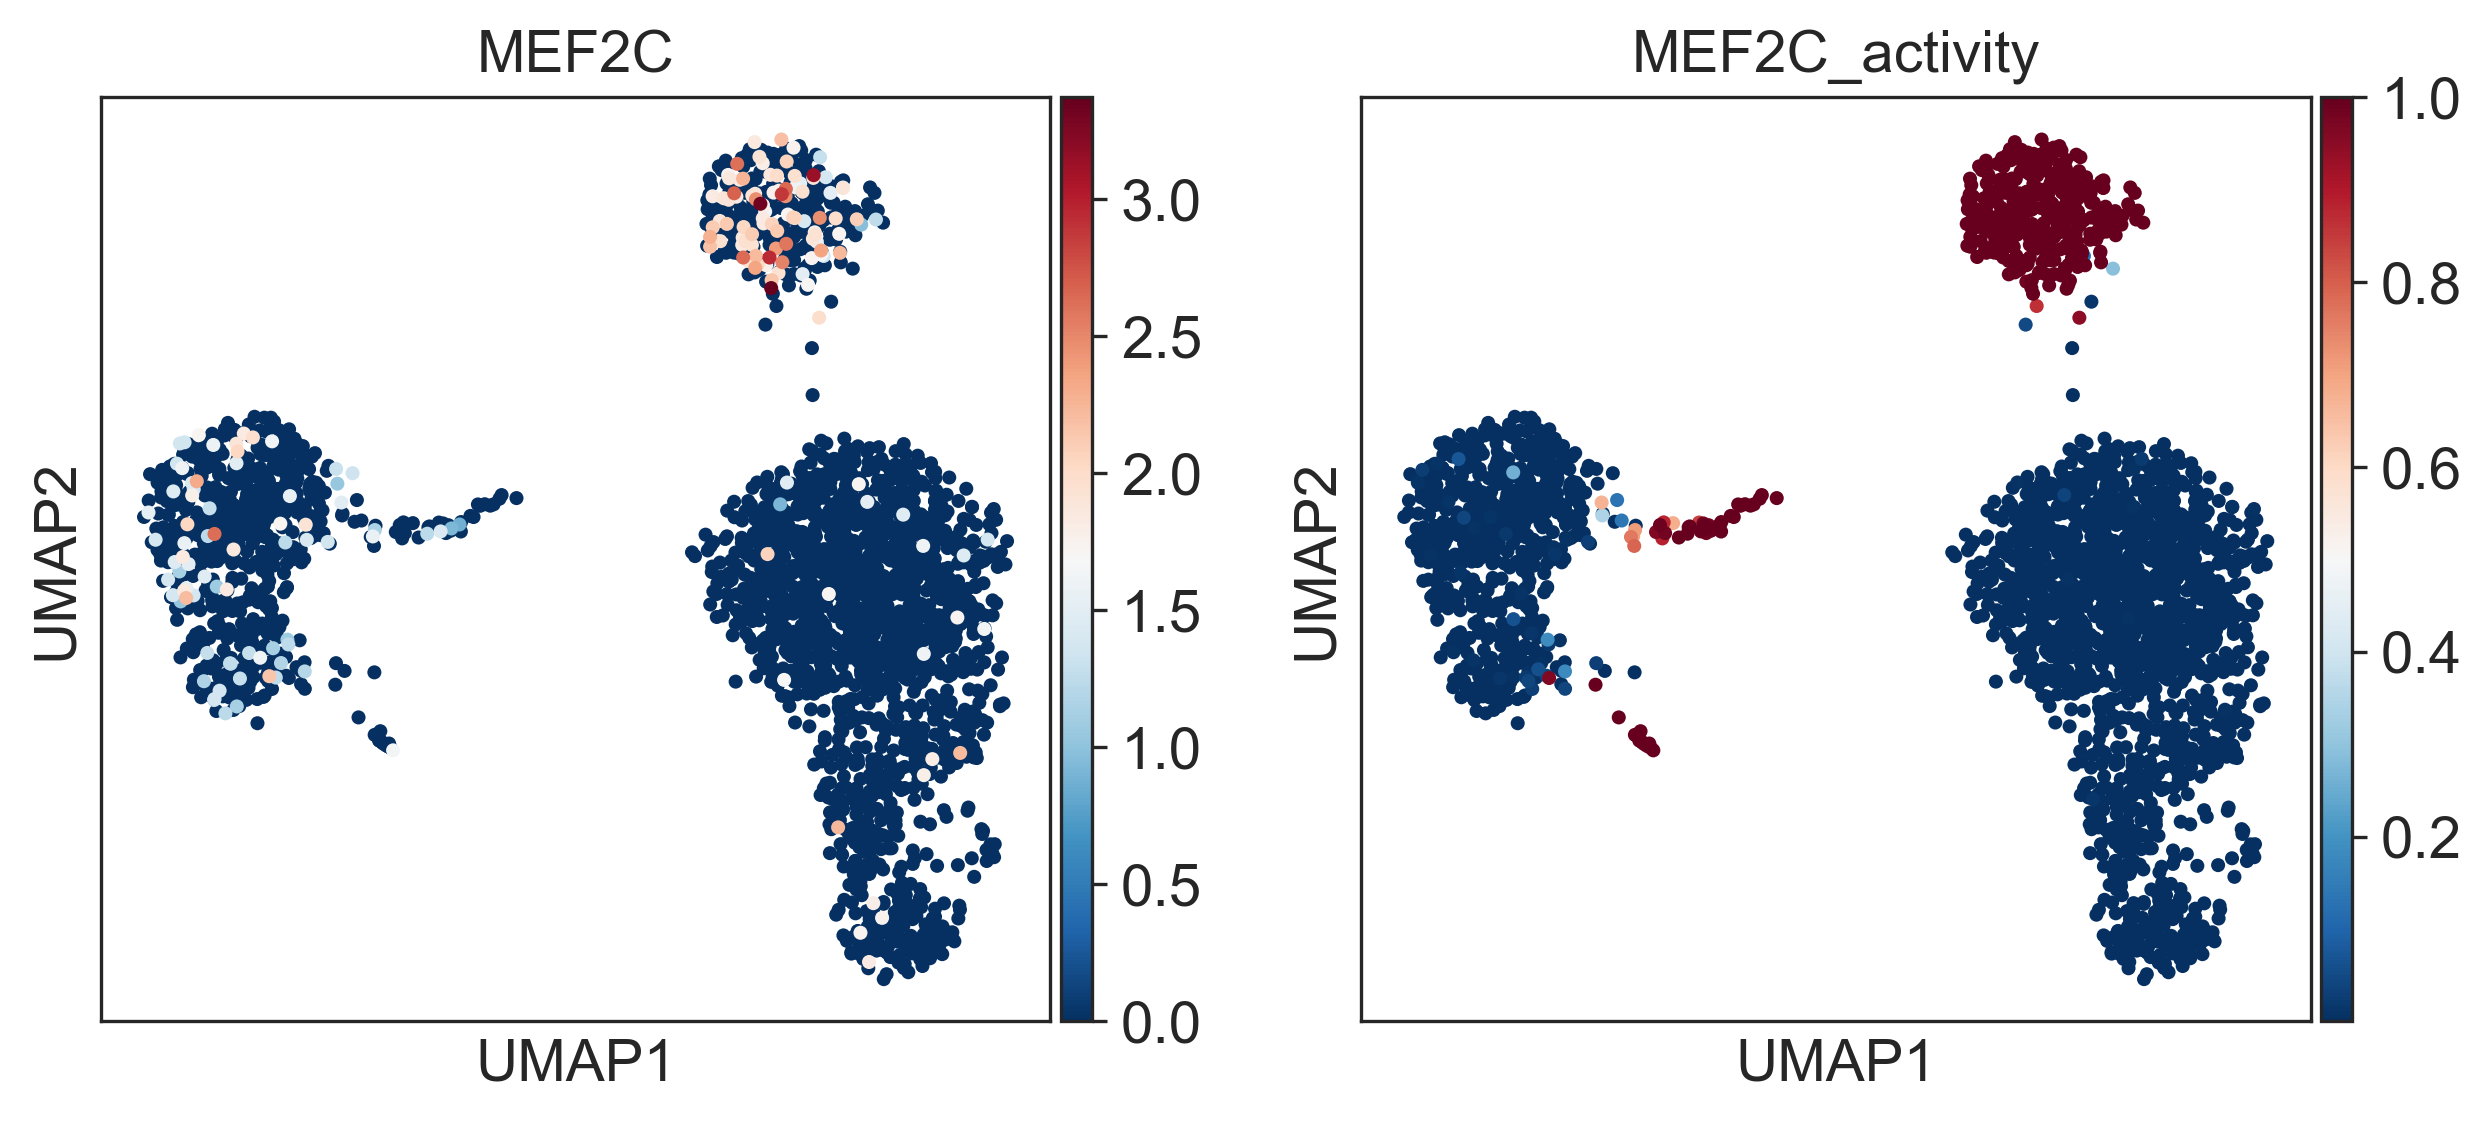

In [21]:
sc.pl.umap(adata, color=["MEF2C", "MEF2C_activity"], cmap="RdBu_r")